In [2]:
# SETUP
## Importing libs
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Random params
np.random.seed(0)
random_state = 338

## Plot params
%matplotlib inline
np.random.seed(0)
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

## Load train and test
test = pd.read_csv('../test.csv', index_col='id')
dT = pd.read_csv('../train.csv', index_col='id')

## Calc stats
# stats = dT.describe()
# statsTarget = stats.pop('claim')
# stats = stats.transpose()
old = dT.copy()
dT['na'] = dT.isna().sum(axis=1)
test['na'] = dT.isna().sum(axis=1)

In [3]:
# (dT.isna().sum(axis=1)/dT.count(axis=1) * 100).describe()
# dT['na_pct'] = dT.isna().sum(axis=1)/
# (scaled.sum(axis=1)*dT['na'].values).head()
# print(scaled.sum(axis=1).describe())
# sns.histplot((scaled.sum(axis=1)*(dT['na'].values-1)))

In [4]:
from sklearn.preprocessing import MinMaxScaler as mms
mmslr = mms()
mmslr.fit(dT)
scaled = pd.DataFrame(mmslr.transform(dT))
scaled.index = dT.index
scaled.columns = dT.columns

# sns.lineplot(data = scaled.loc[scaled['claim']==1].iloc[42,:]);
# sns.lineplot(data = scaled.loc[scaled['claim']==0].iloc[42,:]);

In [22]:
dT['sei_la'] = scaled.sum(axis=1)
dT['na_pct'] = (dT.isna().sum(axis=1)/dT.count(axis=1) * 100)

In [6]:
mmslr2 = mms()
mmslr2.fit(test)
scaledTeste = pd.DataFrame(mmslr2.transform(test))
scaledTeste.index = scaledTeste.index
scaledTeste.columns = scaledTeste.columns



In [23]:
test['na'] = test.isna().sum(axis=1)
# test['mean_diff'] = abs(test - test.mean())**2
test['sei_la'] = scaledTeste.sum(axis=1)
test['na_pct'] = (test.isna().sum(axis=1)/test.count(axis=1) * 100)

In [8]:
# abs(mdif.drop(['claim','claim_zscore','na','na_zscore'])).describe()
# mdif.values
# mdif.drop(['claim','claim_zscore'])
# sns.lineplot(data = abs(mdif.drop(['claim','claim_zscore','na','na_zscore'])));
# mdif = scaled.loc[scaled['claim']==0].mean()-scaled.loc[scaled['claim']==1].mean()
# mms2 = mms()
# mdif2 = mms2.fit_transform([mdif.values])
# # mdif2.index = mdif.index
# mdif2.columns = mdif2.columns

In [9]:
# for col in dT.columns:
#     col_zscore = col + '_zscore'
#     dT[col_zscore] = (dT[col] - dT[col].mean())/dT[col].std(ddof=0)
# dT.head()

In [10]:
# oldT = test.copy()
# test['na'] = test.isna().sum(axis=1)
# for col in test.columns:
#     col_zscore = col + '_zscore'
#     test[col_zscore] = (test[col] - test[col].mean())/dT[col].std(ddof=0)
# test.head()

In [15]:
X = dT.copy()
y = X.pop('claim')
X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f112,f113,f114,f115,f116,f117,f118,na,sei_la,na_pct
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1,0.000000,0.833333
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0,-43.329867,0.000000
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,5,148.752745,4.310345
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,2,41.380998,1.680672
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,8,285.695807,7.079646


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

final_predictions = []
history =[]

# X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

skf = StratifiedKFold(n_splits=2, random_state=random_state, shuffle=True)
skf.get_n_splits(X, y)

for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X=X,y=y)):
    X_train = X.loc[train_indicies]
    X_valid = X.loc[valid_indicies]
    X_test = X_test.copy()

    y_train = y.loc[train_indicies]
    y_valid = y.loc[valid_indicies]

    catBOOST = CatBoostClassifier(
            iterations=500,
                        task_type="GPU",
                        devices='0:1',
                        eval_metric='AUC'
                        )
    catBOOST.fit(X_train,
            y_train,
            verbose=False,
            plot=True)

    preds_valid = catBOOST.predict_proba(X_valid)[:,1]
    preds_test = catBOOST.predict_proba(X_test)[:,1]

    final_predictions.append(preds_test)
    history.append([fold, roc_auc_score(y_valid, preds_valid)])
    print(history[-1])

Learning rate set to 0.044677
0:	learn: 0.8075054	total: 34.2ms	remaining: 17.1s
1:	learn: 0.8134364	total: 63.7ms	remaining: 15.9s
2:	learn: 0.8140485	total: 91.1ms	remaining: 15.1s
3:	learn: 0.8150434	total: 124ms	remaining: 15.4s
4:	learn: 0.8155370	total: 155ms	remaining: 15.3s
5:	learn: 0.8160841	total: 184ms	remaining: 15.1s
6:	learn: 0.8162416	total: 217ms	remaining: 15.2s
7:	learn: 0.8190801	total: 247ms	remaining: 15.2s
8:	learn: 0.8192996	total: 287ms	remaining: 15.7s
9:	learn: 0.8196659	total: 323ms	remaining: 15.8s
10:	learn: 0.8199451	total: 360ms	remaining: 16s
11:	learn: 0.8209427	total: 406ms	remaining: 16.5s
12:	learn: 0.8226494	total: 445ms	remaining: 16.7s
13:	learn: 0.8227876	total: 505ms	remaining: 17.5s
14:	learn: 0.8226842	total: 554ms	remaining: 17.9s
15:	learn: 0.8226416	total: 589ms	remaining: 17.8s
16:	learn: 0.8225958	total: 622ms	remaining: 17.7s
17:	learn: 0.8227294	total: 655ms	remaining: 17.5s
18:	learn: 0.8229211	total: 696ms	remaining: 17.6s
19:	learn:

In [30]:
np.mean(history,0)

array([0.5       , 0.83994859])

[[0, 0.839550081284221], [1, 0.840347106867595]]
0.840347106867595
0.8432377707101398


<AxesSubplot:ylabel='Count'>

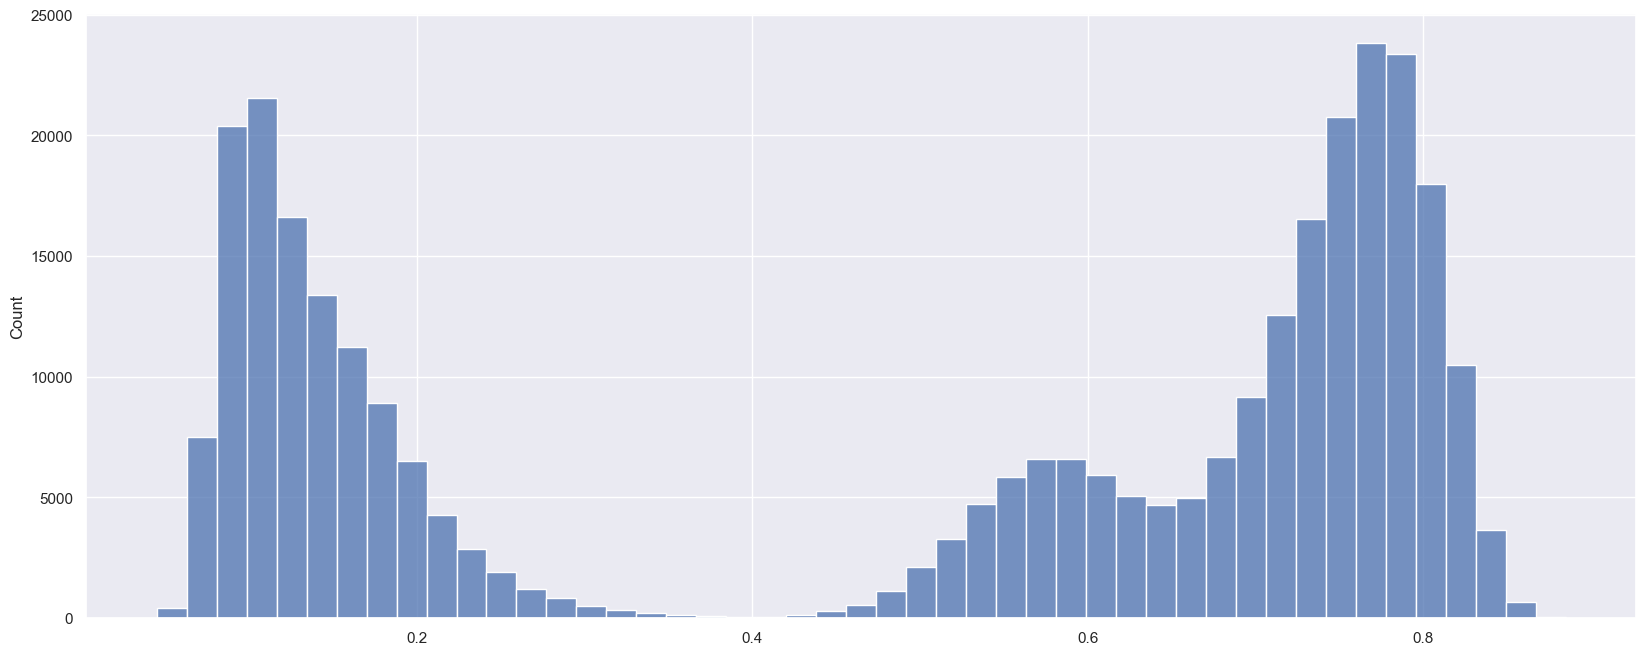

In [32]:
print(history)

maior =0.0
for ii in range(len(history)):
    if history[ii][1]>maior:
        maior = history[ii][1]
        max_index = ii

print(history[max_index][1])
sub = final_predictions[:][max_index]
print(roc_auc_score(y_test,sub))
sns.histplot(data = sub)
# mysub = pd.DataFrame(test.index)
# mysub['claim'] = sub
# mysub['claim'] = mysub['claim'].fillna(0)
# print(mysub.mean()*100)
# mysub['claim'].hist()
# # var = 'cleanCatboost_fDS_zscore_countna_pctNa_scldSUMxCountNA'
# # mysub.to_csv(var+'_submisssion.csv',index=False)